<a href="https://colab.research.google.com/github/kanchan1920/Advanced_CSS/blob/main/DBSCAN_and_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
! git clone https://github.com/kanchan1920/Machine-Learning-based-Hyperspectral-Image-Analysis.git

Cloning into 'Machine-Learning-based-Hyperspectral-Image-Analysis'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from google.colab.patches import cv2_imshow
import math

In [6]:
import warnings
warnings.filterwarnings("ignore")

TypeError: Image data of dtype object cannot be converted to float

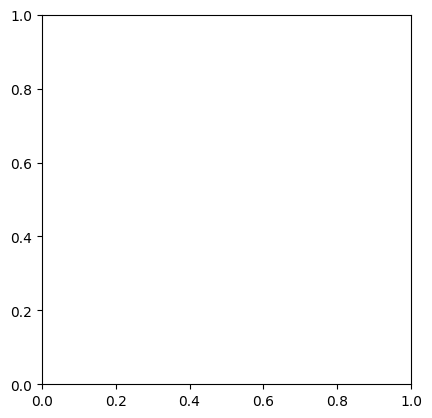

In [7]:
inputName='BHP200506133026.jpg'
img = cv2.imread(inputName)
plt.imshow(img)

In [8]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
print(img.shape)
d1 = img.shape[0]
d2 = img.shape[1]

(250, 250, 3)


In [ ]:
img = img.reshape((d1*d2, 3))
img = pd.DataFrame(img)
x = []
y = []

for i in range(d1):
  for j in range(d2):
    x.append(i)
    y.append(j)
img['x'] = x
img['y'] = y

In [ ]:
img.rename(columns ={0:'0',1:'1',2:'2'},inplace=True)

In [ ]:
db = DBSCAN(eps=6, min_samples=2)
Y_prediction = db.fit_predict(img[['0', '1', '2','x','y']])
Y_prediction

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
img['dbscan']=Y_prediction

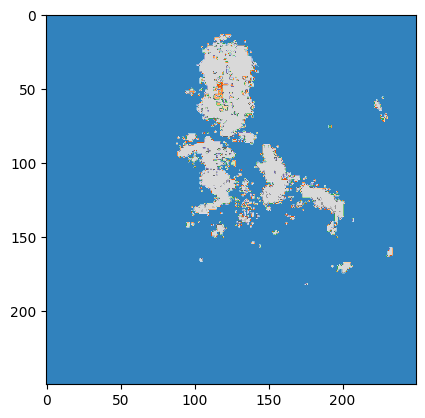

In [ ]:
plt.imshow(np.uint8((np.array(Y_prediction).reshape(d1, d2))))
plt.set_cmap("tab20c")
plt.show()

In [ ]:
KMeans = KMeans(n_clusters=200,random_state=43)
temp_result = KMeans.fit(img[['0','1','2','x','y']])
labels = KMeans.labels_

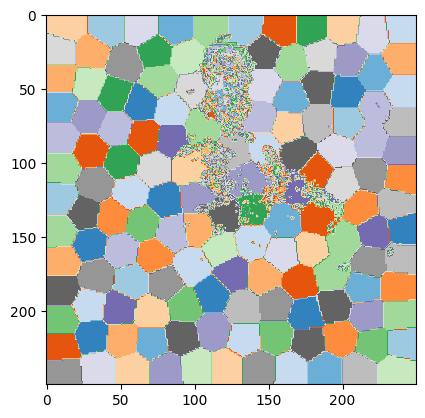

In [ ]:
plt.imshow(np.uint8((np.array(labels).reshape(d1, d2))))
plt.set_cmap("tab20c")
plt.show()

In [ ]:
img['kmeans']=labels

In [ ]:
img

,0,1,2,x,y,dbscan,kmeans
0,0,0,0,0,0,0,75
1,0,0,0,0,1,0,75
2,0,0,0,0,2,0,75
3,0,0,0,0,3,0,75
4,0,0,0,0,4,0,75
...,...,...,...,...,...,...,...
62495,0,0,0,249,245,0,114
62496,0,0,0,249,246,0,114
62497,0,0,0,249,247,0,114
62498,0,0,0,249,248,0,114


In [ ]:
img.to_csv('img.csv',index=False, encoding = 'utf-8-sig')

In [ ]:
""" INTERNAL CLUSTERING INDICES

1.  Within-class and between-class scatter values #
2.  The Ball-Hall index ~

3.  The Banfeld-Raftery index (min) ~#
4.  The Calinski-Harabasz index     #

5.  The Det Ratio index     ~
6.  The Ksq DetW index  ~
7.  The Log Det Ratio index     ~
8.  The Log SS Ratio index      ~

9.  The Scott-Symons index (min)    #
10. The Silhouette index    #
11. The Trace WiB index     ~

12. C-index ~
13. Dunn-index ~

14. Davies-Bouldin index (min)  # (Recheck -- small differences)
15. Ray-Turi index (min)    #

16. Maulik-Bandyopadhyay index (PBM Index)  ~
17. Score Function  ~

18. Hartigan Index  ~

Future Implementation

The Ratkowsky-Lance index

1. CPCC (Heirarchial classification)
2. CDV Index: A Validity Index for Better Clustering Quality Measurement

# Tested
~ Code re-read for testing (unavailabilty of research papers for Testing)
"""

from itertools import combinations
from math import sqrt, log
# import warnings

import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
# from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder


# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)


class InternalIndices:

    def __init__(self,data,labels,distance_matrix=None):

        #normalising labels
        le = LabelEncoder()
        le.fit(labels)

        #initialise class memebers
        self.data=np.array(data)
        '''Note: Treats noise as a seperate (K + 1 th) partition

        References :    [1] https://stats.stackexchange.com/questions/291566/cluster-validation-of-incomplete-clustering-algorithms-esp-density-based-db
        '''
        self.labels=le.transform(labels)

        self.n_samples=self.data.shape[0]
        self.n_features=self.data.shape[1]

        #compute mean of data
        self.data_mean=np.mean(self.data,axis=0)

        #self.n_clusters=np.unique([x for x in self.labels if x>=0]).shape[0] (to avoid noise)
        self.n_clusters=np.unique(self.labels).shape[0]
        self.clusters_mean = np.zeros((self.n_clusters,self.n_features))
        self.clusters_size = np.zeros(self.n_clusters)

        self.insignificant = 1/pow(10,20)
        for cluster_label in range(self.n_clusters):
            #if cluster_label >=0  (to avoid noise)
            cluster_i_pts = (self.labels==cluster_label)
            self.clusters_size[cluster_label] = np.sum(cluster_i_pts)
            self.clusters_mean[cluster_label] = np.mean(self.data[cluster_i_pts],axis=0)

        if distance_matrix is not None:
            self.distance_matrix = distance_matrix

        #print(self.clusters_mean)
        self.compute_scatter_matrices()


    def compute_scatter_matrices(self):
        """
        References: [1] Clustering Indices, Bernard Desgraupes (April 2013)
                    [2] http://sebastianraschka.com/Articles/2014_python_lda.html (Linear Discriminatory Analysis)
                    [3] Chapter 4, Clustering -- RUI XU,DONALD C. WUNSCH, II (IEEE Press)

        verified with data from References [2]
        """
        self.T = total_scatter_matrix(self.data)

        #WG_clusters : WG matrix for each cluster | WGSS_clusters : trace(WG matrix) for each cluster
        self.WG_clusters = np.empty((self.n_clusters,self.n_features,self.n_features),dtype=np.float64)
        self.WGSS_clusters = np.zeros(self.n_clusters,dtype=np.float64)

        #self.BG = np.zeros((self.n_features,self.n_features),dtype=np.float64)

        for cluster_label in range(self.n_clusters):
            #compute within cluster matrix
            self.WG_clusters[cluster_label] = total_scatter_matrix(self.data[self.labels==cluster_label])
            self.WGSS_clusters[cluster_label] = np.trace(self.WG_clusters[cluster_label])

        self.WGSS_clusters_non_zeros_indices = [i for i, e in enumerate(self.WGSS_clusters) if e != 0]

        self.WGSS_clusters_non_zeros_indices_size = len(self.WGSS_clusters_non_zeros_indices)

        #print(self.WGSS_clusters_non_zeros_indices_size)
        self.WGSS_clusters_non_zeros_BR_index = np.zeros(self.WGSS_clusters_non_zeros_indices_size,dtype=np.float64)
        self.clusters_size_BR_index = np.zeros(self.WGSS_clusters_non_zeros_indices_size,dtype=np.float64)
        for cluster_index in range(self.WGSS_clusters_non_zeros_indices_size):
            self.WGSS_clusters_non_zeros_BR_index[cluster_index] = self.WGSS_clusters[self.WGSS_clusters_non_zeros_indices[cluster_index]]
            self.clusters_size_BR_index[cluster_index] = self.clusters_size[self.WGSS_clusters_non_zeros_indices[cluster_index]]

            #compute between-cluster matrix
            mean_vec = self.clusters_mean[cluster_label].reshape((self.n_features,1))
            overall_mean = self.data_mean.reshape((self.n_features,1))

            #self.BG += np.array(self.clusters_size[i]*(mean_vec - overall_mean).dot((mean_vec - overall_mean).T),dtype=np.float64)
            #self.BG = self.BG + self.clusters_size[i]*np.dot(cluster_data_mean_diff.T,cluster_data_mean_diff)

        self.WG = np.sum(self.WG_clusters,axis=0)

        #print(self.WG)

        self.WGSS = np.trace(self.WG)

        self.BG = self.T - self.WG
        #print(self.BG)

        self.BGSS = np.trace(self.BG)

        self.det_WG = np.linalg.det(self.WG)
        self.det_T = np.linalg.det(self.T)


    # internal indices -- start

    def wgss_index(self):
        return self.WGSS

    def bgss_index(self):
        return self.BGSS

    def ball_hall_index(self):
        """
        Ball Hall index -- mean, through all the clusters, of their mean dispersion
        References: [1] Clustering Indices, Bernard Desgraupes (April 2013)
        """
        sum_mean_disperions = 0.

        for cluster_i in range(self.n_clusters):
            sum_mean_disperions += self.WGSS_clusters[cluster_i] / self.clusters_size[cluster_i]

        return sum_mean_disperions/self.n_clusters

    #TODO : verify if denominator inside log is nk (total no. of pts) or nk.(nk-1)/2 (total pairs of points)
    def banfeld_raftery_index(self):
        """Banfeld-Raftery index -- weighted sum of the logarithms of the traces of the variance-
        covariance matrix of each cluster (rule: min)

        References :    [1] Clustering Indices, Bernard Desgraupes (April 2013)
                        [2] https://www.stat.washington.edu/raftery/Research/PDF/banfield1993.pdf

        Tr(W G{k})/nk -- the mean of the squared distances between the points in cluster Ck and their barycenter G{k}.
        If a cluster contains a single point, this trace is equal to 0 and the logarithm is undefined.

        [2] Appropriate for hyperspherical clusters (may be of different sizes)
        """
        #br_index = np.sum(self.clusters_size*np.log(self.WGSS_clusters/self.clusters_size))
        br_index = np.sum(self.clusters_size_BR_index*np.log(self.WGSS_clusters_non_zeros_BR_index/self.clusters_size_BR_index))
        return br_index

    def  det_ratio_index(self):
        """The Determinant Ratio
                Det_R =det(T)/det(WG).
        """
        if(self.det_WG <= 0 or self.det_T <= 0):
            print("replacing with insignificant")
            return self.insignificant
        else:
            return self.det_T/self.det_WG

    def ksq_detw_index(self):
        return self.n_clusters*self.n_clusters*self.det_WG


    def log_det_ratio_index(self):
        if(self.det_WG <= 0 or self.det_T <= 0):
            print("replacing with insignificant")
            return self.insignificant
        else:
            # print("------------T and WG > 0 ------------------")
            #print(self.det_T)
            #print(self.det_WG)
            return self.n_samples * log(self.det_T/self.det_WG)

    def log_ss_ratio_index(self):
        return log(self.BGSS/self.WGSS)

    def scott_symons_index(self):
        """
        Scott-Symons Index -- weighted sum of the logarithms of the determinants of the variance-covariance matrix of each cluster
        """
        scott_symons_index = 0.
        for i in range(self.n_clusters):
            scott_symons_index += self.clusters_size[i]*np.log(np.linalg.det(np.true_divide(self.WG_clusters[i],self.clusters_size[i])))

        return scott_symons_index

    def trace_wib_index(self):
        """
        Trace WiB index -- Maximise (BG/WG), i.e., maximise BG and minimise WG
        """
        if(self.det_WG <= 0  ):
            print("replacing with insignificant because |WG| <= 0")
            return self.insignificant
        else:
            # print("------------T and |WG| > 0 ------------------")
            return np.trace(np.linalg.inv(self.WG).dot(self.BG))

    def silhouette_score(self):
        """Silhouette score (sklearn)

        Reference: [1] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
        """

        #Experiments on silhoutte score -- Partitional Algorithms
        # cluster_data_indices = np.empty((self.n_clusters,),dtype='O')

        # for cluster_index in range(self.n_clusters):
        #   cluster_data_indices[cluster_index] = list(np.where(self.labels==cluster_index))

        # silhouette_coefs = np.zeros((self.n_samples,),dtype='d')
        # for data_index in range(self.n_samples):
        #   avg_intra_dist = euclidean_distances(self.data[[data_index]],self.data[cluster_data_indices[self.labels[data_index]]])[0]
        #   ai = np.sum(avg_intra_dist)/(self.clusters_size[self.labels[data_index]]-1)

        #   bi = np.float64('inf')
        #   for cluster_index in range(self.n_clusters):
        #       if cluster_index == self.labels[data_index]:
        #           continue

        #       avg_inter_dist = euclidean_distances(self.data[[data_index]],self.data[cluster_data_indices[cluster_index]])[0]
        #       current_bi = np.mean(avg_inter_dist)

        #       if current_bi < bi:
        #           bi = current_bi

        #   silhouette_coefs[data_index] = (bi - ai)/max(ai,bi)

        # choosen_indices = list(np.where(silhouette_coefs > threshold))
        # data = self.data[choosen_indices]

        # cmap = sns.cubehelix_palette(as_cmap=True)

        # f, ax = plt.subplots()
        # points = ax.scatter(data.T[0], data.T[1], c=silhouette_coefs[choosen_indices], s=50, cmap=cmap)
        # f.colorbar(points)
        # plt.show()

        #if return_indices:
        #   return silhouette_coefs, choosen_indices

        #return silhouette_coefs

        #return np.mean(silhouette_coefs)
        return metrics.silhouette_score(self.data,self.labels, metric='euclidean')


    def calinski_harabaz_score(self) :
        """Calinski-Harabasz index (sklearn)
        rule : max

        References: [1] http://scikit-learn.org/stable/modules/generated/sklearn.metrics
                    [2] Clustering Indices, Bernard Desgraupes (April 2013)
        """
        return ((self.n_samples - self.n_clusters)/(self.n_clusters - 1)) * (self.BGSS/self.WGSS)
        #return metrics.calinski_harabaz_score(self.data,self.labels)

    def c_index(self):
        """C-index :    range [0,1]
                        rule : min
        """
        Sw = 0.
        Nk = int((np.sum(self.clusters_size**2) - self.n_samples)//2)

        Tk = int(self.n_samples*(self.n_samples-1)//2)

        s_min_max_array = np.empty(Tk)

        #parse through all pair of points
        index = 0
        for data1_index, data2_index in combinations(range(self.n_samples),2):
            #pre-computing distances
            distance = euclidean_distance(self.data[data1_index],self.data[data2_index])

            if self.labels[data1_index] == self.labels[data2_index]:
                Sw += distance

            s_min_max_array[index] = distance
            index += 1

            #print(str(data1_index)+"  "+str(data2_index    )+"completed")
        s_min_max_array.sort()

        s_min = np.sum(s_min_max_array[:Nk])
        s_max = np.sum(s_min_max_array[Tk-Nk:])

        #print(Sw,s_min_max_array.k_largest,s_min_max_array.k_smallest)
        return (Sw - s_min)/(s_max - s_min)

    def dunn_index(self):
        """Dunn index -- ratio between the minimal intracluster distance to maximal intercluster distance
        Note : computationally expensive and sensitive to noisy data

        References :    [1] https://www.biomedcentral.com/content/supplementary/1471-2105-9-90-S2.pdf

        range : [0,infinity) | rule : max
        """
        max_intra_cluster = min_inter_cluster = euclidean_distance(self.data[0],self.data[1])

        #parse through all pair of points
        for data1_index,data2_index in combinations(range(self.n_samples),2):
            distance = euclidean_distance(self.data[data1_index],self.data[data2_index])

            #both are same cluster
            if (self.labels[data1_index] == self.labels[data2_index]) and (distance > max_intra_cluster):
                max_intra_cluster = distance

            elif (self.labels[data1_index] != self.labels[data2_index]) and (distance < min_inter_cluster):
                min_inter_cluster = distance
            if(max_intra_cluster <=0):
                return 0
        return min_inter_cluster/max_intra_cluster

    def davies_bouldin_index(self):
        """ Davies-Bouldin index -- Small values of DB correspond to clusters that are compact, and whose
            centers are far away from each other.

            References :    [1] https://www.biomedcentral.com/content/supplementary/1471-2105-9-90-S2.pdf
                            [2] https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
                            [3] https://pdfs.semanticscholar.org/9701/405b0d601e169636a2541940a070087acd5b.pdf
        """

        total_clusters_dispersion = np.zeros(self.n_clusters)

        for data_index in range(self.n_samples):

            total_clusters_dispersion[self.labels[data_index]] += euclidean_distance(self.data[data_index],self.clusters_mean[self.labels[data_index]])


        mean_clusters_dispersion = total_clusters_dispersion / self.clusters_size
        #mean_clusters_dispersion = np.sqrt(self.WGSS_clusters/self.clusters_size)

        sum_Mk = 0.

        for cluster_i in range(self.n_clusters):
            max_Mk = 0.
            for cluster_j in range(self.n_clusters):
                if cluster_i != cluster_j :
                    Mk = (mean_clusters_dispersion[cluster_i] + mean_clusters_dispersion[cluster_j])/euclidean_distance(self.clusters_mean[cluster_i],self.clusters_mean[cluster_j])
                    if Mk > max_Mk :
                        max_Mk = Mk

            sum_Mk += max_Mk

        return sum_Mk/self.n_clusters

    def ray_turi_index(self):
        """
        Ray-Turi Index
        References  :   [1] Clustering Indices, Bernard Desgraupes (April 2013)
        """
        min_cluster_mean_diff = euclidean_distance(self.clusters_mean[0],self.clusters_mean[1],squared=True)
        for cluster_mean1,cluster_mean2 in combinations(self.clusters_mean,2):
            mean_diff = euclidean_distance(cluster_mean1,cluster_mean2,squared=True)
            if mean_diff < min_cluster_mean_diff:
                min_cluster_mean_diff = mean_diff

        return self.WGSS/(min_cluster_mean_diff*self.n_samples)

    def hartigan_index(self):
        """
        Hartigan Index : generally used to find no. cluster in a dataset (used only for K-Means Algorithm)
        Optimum number of clusters : K for which Hartigan(K) <= n (usually, n=10)

        References :    [1] http://suendermann.com/su/pdf/ijcbs2009.pdf
        """

        no_clusters = self.n_clusters+1

        #perfrom Kmeans of the data with K+1 clusters
        kmeans_clusterer=KMeans(n_clusters=no_clusters)
        labels = kmeans_clusterer.fit_predict(self.data)

        total_dispersion = 0.

        for cluster_i in range(no_clusters):
            cluster_i_pts = self.data[(labels==cluster_i)]
            cluster_i_mean = np.mean(cluster_i_pts)

            cluster_i_dispersion = np.sum((cluster_i_pts - cluster_i_mean)**2)
            total_dispersion += cluster_i_dispersion

        return (self.n_samples-self.n_clusters-1)*(self.WGSS-total_dispersion)/total_dispersion

    def pbm_index(self):
        """Maulik-Bandyopadhyay index (aka. I-index, PBM Index)

        References  :   [1] https://pdfs.semanticscholar.org/9701/405b0d601e169636a2541940a070087acd5b.pdf
                        [2] Clustering Indices, Bernard Desgraupes (April 2013)
                        [3] ClusterCrit: https://cran.r-project.org/web/packages/clusterCrit/vignettes/clusterCrit.pdf

        Maulik, U., Bandyopadhyay, S.: Performance evaluation of some clustering algorithms and validity indices. IEEE Transactions Pattern Analysis Machine Intelligence 24(12) (2002) 1650–1654

        rule : max
        """
        max_DB = 0.
        for cluster_i,cluster_j in combinations(range(self.n_clusters),2):
            DB = euclidean_distance(self.clusters_mean[cluster_i],self.clusters_mean[cluster_j])
            if DB > max_DB:
                max_DB = DB

        Ew,Et = 0.,0.
        for data_index in range(self.n_samples):
            Ew += euclidean_distance(self.data[data_index],self.clusters_mean[self.labels[data_index]])
            Et += euclidean_distance(self.data[data_index],self.data_mean)
        if ((self.n_clusters * Ew) == 0):
            return (1e-20)
        return np.power((Et * max_DB)/(self.n_clusters * Ew),2)

    def score_function(self):
        """Score Function - SF : works good for hyper-speriodal data

        References :    [1] https://pdfs.semanticscholar.org/9701/405b0d601e169636a2541940a070087acd5b.PDF

        range : ]0,1[ | rule : max
        """
        #is centroid of all clusters = data_mean
        bcd = np.sum(np.sqrt(np.sum((self.clusters_mean - self.data_mean)**2,axis=1))*self.clusters_size)/(self.n_clusters*self.n_samples)

        #print(bcd)

        clusters_dispersion = np.zeros(self.n_clusters)
        for data_index in range(self.n_samples):
            clusters_dispersion[self.labels[data_index]] += euclidean_distance(self.data[data_index],self.clusters_mean[self.labels[data_index]])

        wcd = np.sum(clusters_dispersion / self.clusters_size)
        #print(wcd)
        return (1 - 1/np.exp(np.exp(bcd - wcd)))

    # internal indices -- end

# helper functions -- start
def total_scatter_matrix(data):
    """
    Total sum of square (TSS) : sum of squared distances of points around the baycentre
    References : Clustering Indices, Bernard Desgraupes (April 2013)
    """
    X=np.array(data.T.copy(),dtype=np.float64)

    for feature_i in range(data.shape[1]):
        X[feature_i] = X[feature_i] - np.mean(X[feature_i])

    T = np.dot(X,X.T)
    return T

def euclidean_distance(vector1,vector2,squared=False):
    """calculates euclidean distance between two vectors

    Keyword arguments:
    vector1 -- first data point (type: numpy array)
    vector2 -- second data point (type: numpy array)
    squared -- return square of euclidean distance (default: False)
    """
    euclidean_distance=np.sum((vector1-vector2)**2)

    if squared is False:
        euclidean_distance=sqrt(euclidean_distance)

    return euclidean_distance

# helper functions -- end


INTERNAL_INDICES_METHOD_NAMES_DICT = {
    'WGSS' : 'wgss_index',
    'BGSS': 'bgss_index',
    'Ball-Hall' : 'ball_hall_index',
    'Banfeld-Raftery' : 'banfeld_raftery_index',
    'Det-Ratio' : 'det_ratio_index',
    'Ksq-DetW' : 'ksq_detw_index',
    'Log-Det-Ratio' : 'log_det_ratio_index',
    'Log-SS-Ratio' : 'log_ss_ratio_index',
    'Scott-Symons' : 'scott_symons_index',
    'Trace-WiB' : 'trace_wib_index',
    'Silhouette' : 'silhouette_score',
    'Calinski-Harabasz' : 'calinski_harabaz_score',
    'C' : 'c_index',
    'Dunn' : 'dunn_index',
    'Davies-Bouldin' : 'davies_bouldin_index',
    'Ray-Turi' : 'ray_turi_index',
    'Hartigan' : 'hartigan_index',
    'PBM' : 'pbm_index',
    'Score' : 'score_function'
}

In [ ]:
img=pd.read_csv('img.csv',skipinitialspace=True)
img=img.reset_index()
# img.rename(columns ={"0":0,"1":1,"2":2},inplace=True)

For DBSCAN

In [ ]:
internal_validation = InternalIndices(img[['0','1','2','x','y']],img['dbscan'])
db_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Davies-Bouldin'])
ch_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Calinski-Harabasz'])
silhouette_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Silhouette'])
ball_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Ball-Hall'])
Ray_turi_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Ray-Turi'])
print("DB Score: ",db_index_method())
print("CH Score: ",ch_index_method())
print("Silhouette Score: ",silhouette_index_method())
print("Ball Hall Index: ",ball_index_method())
print("Ray Turi Index: ",Ray_turi_index_method())

DB Score:  1.556546511698928
CH Score:  41.97038271495219
Silhouette Score:  -0.6233007643705671
Ball Hall Index:  103.29646511465307
Ray Turi Index:  271.1396013796235


For K-Means

In [ ]:
internal_validation = InternalIndices(img[['0','1','2','x','y']],img['kmeans'])
db_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Davies-Bouldin'])
ch_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Calinski-Harabasz'])
silhouette_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Silhouette'])
ball_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Ball-Hall'])
Ray_turi_index_method = getattr(internal_validation, INTERNAL_INDICES_METHOD_NAMES_DICT['Ray-Turi'])
print("DB Score: ",db_index_method())
print("CH Score: ",ch_index_method())
print("Silhouette Score: ",silhouette_index_method())
print("Ball Hall Index: ",ball_index_method())
print("Ray Turi Index: ",Ray_turi_index_method())

DB Score:  0.9522680065030122
CH Score:  32205.79038963895
Silhouette Score:  0.30798783090430665
Ball Hall Index:  324.5943784368734
Ray Turi Index:  0.4389152407883562


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

def ray_turi_index(X, labels):
    """
    Calculates the Ray-Turi Index for a clustering with 5-dimensional data points.

    Parameters:
    X (numpy array): The data points with shape (n_samples, n_features).
    labels (numpy array): The labels for each data point with shape (n_samples,).

    Returns:
    The Ray-Turi Index for the clustering.
    """
    n_clusters = len(np.unique(labels))
    centroids = np.zeros((n_clusters, X.shape[1]))

    for i in range(n_clusters):
        mask = labels == i
        centroids[i] = X[mask].mean(axis=0)

    within_cluster_distances = np.zeros(n_clusters)
    between_cluster_distances = 0

    for i in range(n_clusters):
        mask = labels == i
        cluster_distances = pairwise_distances(X[mask], [centroids[i]], metric='euclidean')
        within_cluster_distances[i] = np.mean(cluster_distances)

    between_cluster_distances = pairwise_distances(centroids, metric='euclidean').mean()

    return np.mean(within_cluster_distances) / between_cluster_distances


In [ ]:
img['dbscan'].min()

-1

In [ ]:
ray_turi_index(img[['0','1','2','x','y']],np.array(img['dbscan'])+1)

0.02574928695894624

In [ ]:
ray_turi_index(img[['0','1','2','x','y']],img['kmeans'])

0.18244349497058285